In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil

import torch
import optuna
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from sklearn import metrics
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.transforms import v2

In [2]:
# Global vars
SRC_PATH = './data/train'
SUBSET_PATH = './data/subset'
RARESET_PATH = './data//rareset'
SUBSET_TRAIN_PATH = './data/train'
SUBSET_VAL_PATH = './data/val'
SUBSET_TEST_PATH = './data/test'
RARESET_TRAIN_PATH = './data/train'
RARESET_VAL_PATH = './data/val'
RARESET_TEST_PATH = './data/test'

BATCH_SIZE = 10
NUM_EPOCH = 50
LR = 1e-4
DEVICE = 'cuda'

In [3]:
def copy_images(SRC: str, DST: str, category: str, start: int, count: int):
    """
    Copy image from SRC to DST
    """
    for i in range(start, start + count, 1):
        sfile = os.path.join(SRC, f'{category}.{i}.jpg')
        dfile = os.path.join(DST, f'{category}.{i}.jpg')
        shutil.copy(sfile, dfile)


def create_subset():
    """
    Create subset from dog_vs_cat, which contain three subsets:
    1. Training set: 1000 samples from each class, from {cat/dog}.0.jpg to {cat/dog}.999.jpg
    2. Validation set: 500 samples from each class, from {cat/dog}.1000.jpg to {cat/dog}.1499.jpg
    3. Test set: 500 samples from each class, from {cat/dog}.1500.jpg to {cat/dog}.1999.jpg
    """
    if os.path.exists(SUBSET_PATH):
        print(f'Path: {SUBSET_PATH} existed.')
    else:
        os.makedirs(SUBSET_PATH)
        os.makedirs(f'{SUBSET_PATH}/train')
        os.makedirs(f'{SUBSET_PATH}/val')
        os.makedirs(f'{SUBSET_PATH}/test')
        copy_images(SRC_PATH, f'{SUBSET_PATH}/train', 'cat', 0, 1000)
        copy_images(SRC_PATH, f'{SUBSET_PATH}/train', 'dog', 0, 1000)
        copy_images(SRC_PATH, f'{SUBSET_PATH}/val', 'cat', 1000, 500)
        copy_images(SRC_PATH, f'{SUBSET_PATH}/val', 'dog', 1000, 500)
        copy_images(SRC_PATH, f'{SUBSET_PATH}/test', 'cat', 1500, 500)
        copy_images(SRC_PATH, f'{SUBSET_PATH}/test', 'dog', 1500, 500)
        print(f'Subset created.')


def create_rareset():
    """
    Create subset with rare event from dog_vs_cat, which contain three subsets:
    1. Training set: 1000 samples from dog, 100 samples from cat
    2. Validation set: 500 samples from dog, 50 samples from cat
    3. Test set: 500 samples from dog, 50 samples from cat
    """
    if os.path.exists(RARESET_PATH):
        print(f'Path: {RARESET_PATH} existed.')
    else:
        os.makedirs(RARESET_PATH)
        os.makedirs(f'{RARESET_PATH}/train')
        os.makedirs(f'{RARESET_PATH}/val')
        os.makedirs(f'{RARESET_PATH}/test')
        copy_images(SRC_PATH, f'{RARESET_PATH}/train', 'cat', 0, 100)
        copy_images(SRC_PATH, f'{RARESET_PATH}/train', 'dog', 0, 1000)
        copy_images(SRC_PATH, f'{RARESET_PATH}/val', 'cat', 1000, 50)
        copy_images(SRC_PATH, f'{RARESET_PATH}/val', 'dog', 1000, 500)
        copy_images(SRC_PATH, f'{RARESET_PATH}/test', 'cat', 1500, 50)
        copy_images(SRC_PATH, f'{RARESET_PATH}/test', 'dog', 1500, 500)
        print(f'Rareset created.')


# Download dataset from kaggle
# !kaggle competitions download -c dogs-vs-cats
# !unzip dogs-vs-cats.zip
# !unzip train.zip
# Create subset from dataset
create_subset()
create_rareset()

Path: ../../datasets/dog_vs_cat/subset existed.
Path: ../../datasets/dog_vs_cat/rareset existed.


In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(64, 128, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Flatten(),
            nn.Linear(6272, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.seq(x)



In [5]:
# Custom dataset
class DogCatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(self.root_dir)
        self.label_dict = {
            'cat': torch.tensor(0, dtype=torch.float32),
            'dog': torch.tensor(1, dtype=torch.float32),
        }

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        img = Image.open(img_name)
        label = self.file_list[idx].split('.')[0]
        if self.transform:
            img = self.transform(img)
        return img, self.label2float(label)

    def label2float(self, label):
        return self.label_dict[label]


# Image transformer
transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize((150, 150)),
])

# Load dataset
dataset_train = DogCatDataset(root_dir=SUBSET_TRAIN_PATH, transform=transform)
dataset_val = DogCatDataset(root_dir=SUBSET_VAL_PATH, transform=transform)
dataset_test = DogCatDataset(root_dir=SUBSET_TEST_PATH, transform=transform)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
def train(model, criterion, optimizer, num_epoch, device, data_train, data_val, verbose=True):
    model = model.to(device)
    epoch_hist = []
    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []
    for epoch in range(num_epoch):
        epoch_hist.append(epoch)
        # Train
        model.train()
        train_batch_count = 0
        train_batch_loss = 0.0
        train_batch_acc = 0.0
        for images, labels in data_train:
            # To GPU
            images = images.to(device)
            labels = labels.to(device)
            # Forward
            out = model(images).flatten()
            # Loss
            loss = criterion(out, labels)
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Record
            train_batch_count += 1
            train_batch_loss += loss
            train_batch_acc += (out.round() == labels).float().mean()
        # Info
        train_loss_hist.append((train_batch_loss / train_batch_count).cpu().detach().numpy())
        train_acc_hist.append((train_batch_acc / train_batch_count).cpu().detach().numpy())
        if verbose:
            print(f'Train epoch: {epoch}, avg loss: {train_loss_hist[-1]}, avg acc: {train_acc_hist[-1]}')
        # Eval
        model.eval()
        with torch.no_grad():
            val_batch_count = 0
            val_batch_loss = 0.0
            val_batch_acc = 0.0
            for images, labels in data_val:
                images = images.to(device)
                labels = labels.to(device)
                out = model(images).flatten()
                loss = criterion(out, labels)
                val_batch_count += 1
                val_batch_loss += loss
                val_batch_acc += (out.flatten().round() == labels).float().mean()
            val_loss_hist.append((val_batch_loss / val_batch_count).cpu().detach().numpy())
            val_acc_hist.append((val_batch_acc / val_batch_count).cpu().detach().numpy())
            if verbose:
                print(f'Val epoch: {epoch}, avg loss: {val_loss_hist[-1]}, avg acc: {val_acc_hist[-1]}')
    return epoch_hist, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist


def predict(model, data_test, device):
    y_true = []
    y_pred = []
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for images, labels in data_test:
            y_true.extend(labels.cpu().detach().numpy())
            images = images.to(device)
            out = model(images).flatten()
            y_pred.extend(out.cpu().detach().numpy())
    return y_true, y_pred



In [7]:
def plot_loss_acc(epoch_hist: list, train_acc_hist: list, train_loss_hist: list, val_acc_hist: list, val_loss_hist: list):
    # Train
    plt.figure()
    plt.plot(epoch_hist, train_acc_hist, 'bo', label='Train acc')
    plt.plot(epoch_hist, train_loss_hist, 'b', label='Train loss')
    plt.title('Training loss and accuracy')
    plt.legend()
    # Val
    plt.figure()
    plt.plot(epoch_hist, val_acc_hist, 'bo', label='Val acc')
    plt.plot(epoch_hist, val_loss_hist, 'b', label='val loss')
    plt.title('Validation loss and accuracy')
    plt.legend()
    # Show
    plt.show()


def plot_roc_auc(y_true: list, y_pred: list):
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    # Plot
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    disp.plot()


def plot_recall_precision(y_true: list, y_pred):
    # Recall
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    # Plot
    disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()


def plot_confusion_matrix(y_true: list, y_pred: list):
    y_true = np.array(y_true).astype(np.int32)
    y_pred = np.array(y_pred).round().astype(np.int32)
    # Confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, labels=(0, 1))
    # Plot
    disp = metrics.ConfusionMatrixDisplay(cm, display_labels=(0, 1))
    disp.plot()



Train epoch: 0, avg loss: 0.6931842565536499, avg acc: 0.5229999423027039
Val epoch: 0, avg loss: 0.694412350654602, avg acc: 0.49999988079071045
Train epoch: 1, avg loss: 0.6830806732177734, avg acc: 0.5619996786117554
Val epoch: 1, avg loss: 0.6719581484794617, avg acc: 0.5469999313354492
Train epoch: 2, avg loss: 0.6618098020553589, avg acc: 0.5989998579025269
Val epoch: 2, avg loss: 0.6486635208129883, avg acc: 0.6029999852180481
Train epoch: 3, avg loss: 0.6364198327064514, avg acc: 0.6434999108314514
Val epoch: 3, avg loss: 0.6244059801101685, avg acc: 0.6449997425079346
Train epoch: 4, avg loss: 0.6152927875518799, avg acc: 0.6570001840591431
Val epoch: 4, avg loss: 0.6022027730941772, avg acc: 0.6759998202323914
Train epoch: 5, avg loss: 0.5960941910743713, avg acc: 0.6840000748634338
Val epoch: 5, avg loss: 0.5978503823280334, avg acc: 0.6879997849464417
Train epoch: 6, avg loss: 0.5635183453559875, avg acc: 0.7189999222755432
Val epoch: 6, avg loss: 0.5740349292755127, avg ac

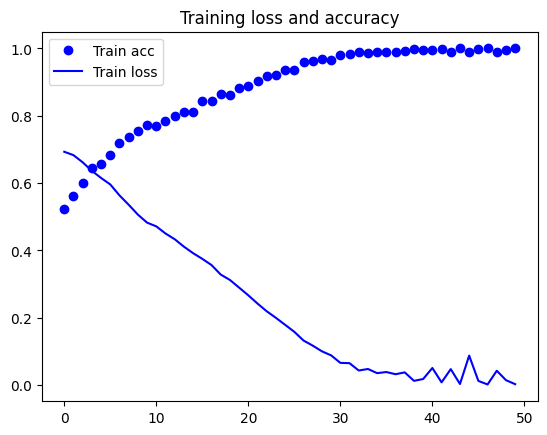

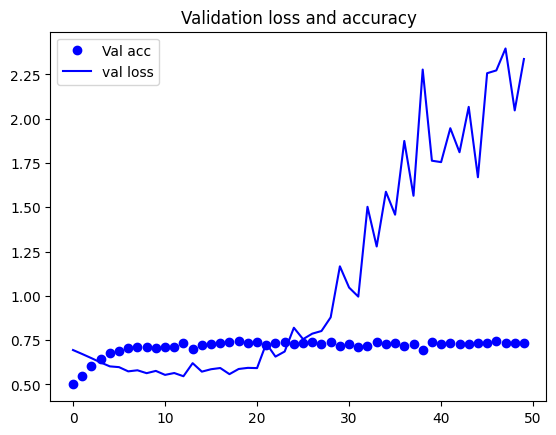

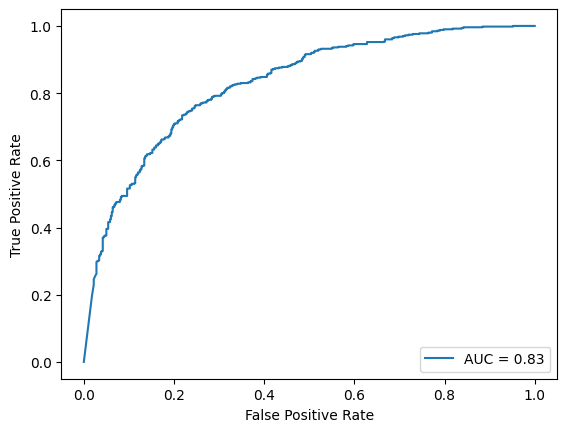

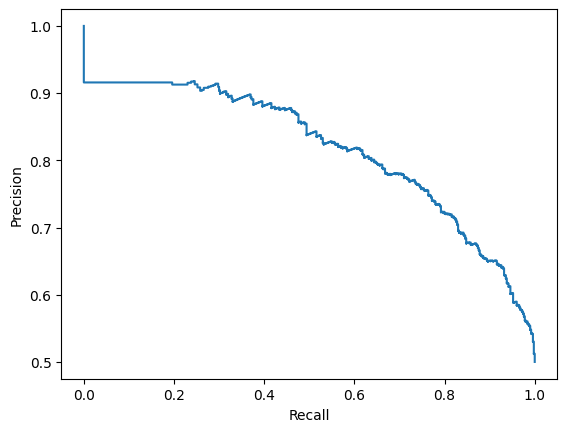

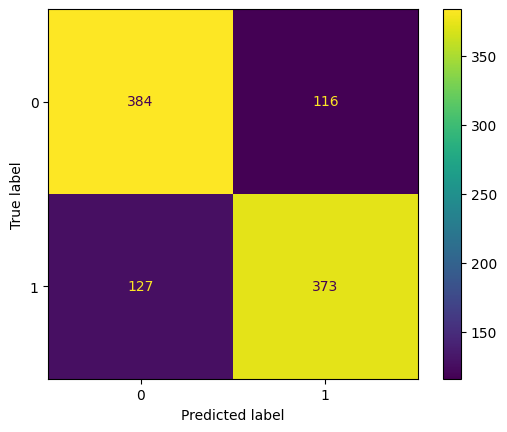

In [8]:
model = ConvNet().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

epoch_hist, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(model, criterion, optimizer, NUM_EPOCH, DEVICE, dataloader_train, dataloader_val)
y_true, y_pred = predict(model, dataloader_test, DEVICE)

plot_loss_acc(epoch_hist, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist)
plot_roc_auc(y_true, y_pred)
plot_recall_precision(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred)

In [9]:
# Image transformer with data augmentation
transform_with_aug = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize((150, 150)),
    v2.RandomRotation((0, 40)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.2),
    v2.RandomCrop((150, 150)),
    # v2.RandomZoomOut(0.2),
    # v2.Pad(padding=0, padding_mode='reflect'),
])

# Load dataset
dataset_train_aug = DogCatDataset(root_dir=SUBSET_TRAIN_PATH, transform=transform_with_aug)
dataloader_train_aug = DataLoader(dataset_train_aug, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
class ConvNetWithDropout(nn.Module):
    def __init__(self):
        super(ConvNetWithDropout, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(64, 128, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(6272, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.seq(x)


Train epoch: 0, avg loss: 0.6928676962852478, avg acc: 0.5154998302459717
Val epoch: 0, avg loss: 0.6839543581008911, avg acc: 0.5940001010894775
Train epoch: 1, avg loss: 0.6759769320487976, avg acc: 0.583999752998352
Val epoch: 1, avg loss: 0.6427855491638184, avg acc: 0.6480001211166382
Train epoch: 2, avg loss: 0.6550673246383667, avg acc: 0.6205000281333923
Val epoch: 2, avg loss: 0.6242454648017883, avg acc: 0.669999897480011
Train epoch: 3, avg loss: 0.6351577043533325, avg acc: 0.6489996314048767
Val epoch: 3, avg loss: 0.6555095314979553, avg acc: 0.6109997630119324
Train epoch: 4, avg loss: 0.6276959180831909, avg acc: 0.6529996395111084
Val epoch: 4, avg loss: 0.6153139472007751, avg acc: 0.6740001440048218
Train epoch: 5, avg loss: 0.6165244579315186, avg acc: 0.6709997653961182
Val epoch: 5, avg loss: 0.603624701499939, avg acc: 0.6719999313354492
Train epoch: 6, avg loss: 0.6077119708061218, avg acc: 0.6714996099472046
Val epoch: 6, avg loss: 0.5893987417221069, avg acc: 

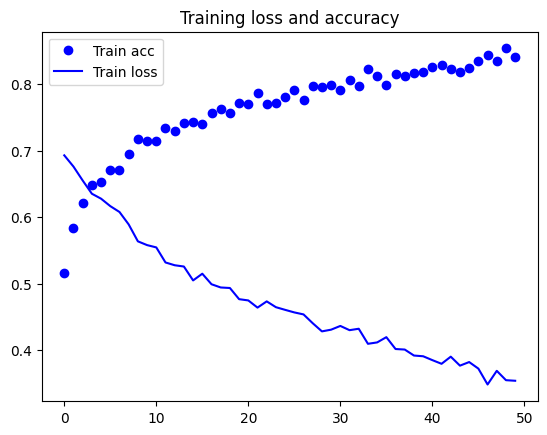

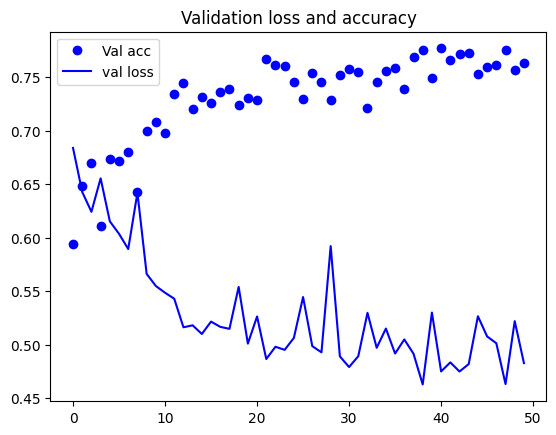

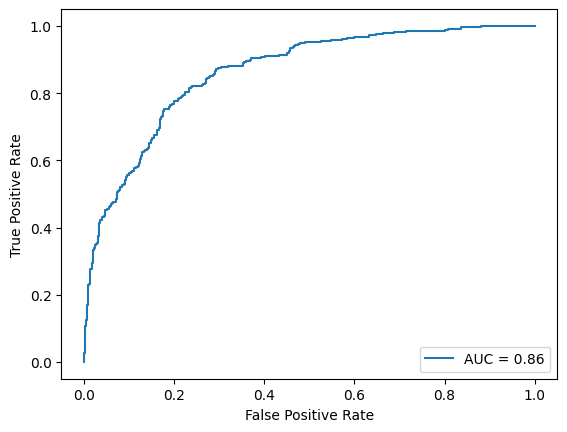

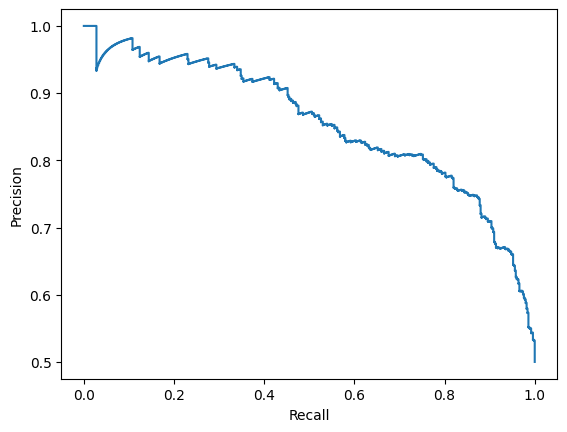

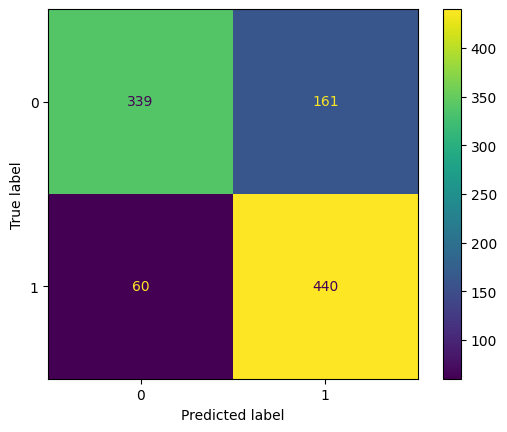

In [11]:
model_aug = ConvNetWithDropout()
criterion_aug = nn.BCELoss()
optimizer_aug = torch.optim.RMSprop(model_aug.parameters(), lr=LR)

epoch_hist_aug, train_loss_hist_aug, train_acc_hist_aug, val_loss_hist_aug, val_acc_hist_aug = train(model_aug, criterion_aug, optimizer_aug, NUM_EPOCH, DEVICE, dataloader_train_aug, dataloader_val)
y_true_aug, y_pred_aug = predict(model_aug, dataloader_test, DEVICE)

plot_loss_acc(epoch_hist_aug, train_acc_hist_aug, train_loss_hist_aug, val_acc_hist_aug, val_loss_hist_aug)
plot_roc_auc(y_true_aug, y_pred_aug)
plot_recall_precision(y_true_aug, y_pred_aug)
plot_confusion_matrix(y_true_aug, y_pred_aug)

In [16]:
def objective_convnet(trial):
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-3)
    model = ConvNetWithDropout()
    criterion = nn.BCELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    _, _, _, _, val_acc_hist = train(model, criterion, optimizer, NUM_EPOCH, DEVICE, dataloader_train_aug, dataloader_val, verbose=False)
    return val_acc_hist[-1]


study_convnet = optuna.create_study(direction="maximize")
study_convnet.optimize(objective_convnet, n_trials=10)
best_trial = study_convnet.best_trial
print(f'Best trial:')
print(f'  Value: {best_trial.value}')
for k, v in best_trial.params.items():
    print(f'  {k}: {v}')


[I 2023-10-07 22:32:23,823] A new study created in memory with name: no-name-338c5bb6-9e9d-4113-80cf-d86db71c1e44
[I 2023-10-07 22:42:04,426] Trial 0 finished with value: 0.8080004453659058 and parameters: {'learning_rate': 0.000354533394005753}. Best is trial 0 with value: 0.8080004453659058.
[I 2023-10-07 22:51:45,248] Trial 1 finished with value: 0.7630000114440918 and parameters: {'learning_rate': 5.354018468678279e-05}. Best is trial 0 with value: 0.8080004453659058.
[I 2023-10-07 23:01:38,377] Trial 2 finished with value: 0.8080000877380371 and parameters: {'learning_rate': 0.0006109763193831065}. Best is trial 0 with value: 0.8080004453659058.
[I 2023-10-07 23:11:15,054] Trial 3 finished with value: 0.7600001096725464 and parameters: {'learning_rate': 4.932474917081429e-05}. Best is trial 0 with value: 0.8080004453659058.
[I 2023-10-07 23:20:48,756] Trial 4 finished with value: 0.7710001468658447 and parameters: {'learning_rate': 7.905634530353533e-05}. Best is trial 0 with valu

Best trial:
  Value: 0.8080004453659058
  learning_rate: 0.000354533394005753


Train epoch: 0, avg loss: 0.3331281244754791, avg acc: 0.9000004529953003
Val epoch: 0, avg loss: 0.3167530596256256, avg acc: 0.9090909361839294
Train epoch: 1, avg loss: 0.3054038882255554, avg acc: 0.9090912342071533
Val epoch: 1, avg loss: 0.34413808584213257, avg acc: 0.9090909361839294
Train epoch: 2, avg loss: 0.3062719702720642, avg acc: 0.9090913534164429
Val epoch: 2, avg loss: 0.33641675114631653, avg acc: 0.9090909361839294
Train epoch: 3, avg loss: 0.305162250995636, avg acc: 0.9090912342071533
Val epoch: 3, avg loss: 0.30466321110725403, avg acc: 0.9090909361839294
Train epoch: 4, avg loss: 0.3002541661262512, avg acc: 0.9090913534164429
Val epoch: 4, avg loss: 0.3128041625022888, avg acc: 0.9090909361839294
Train epoch: 5, avg loss: 0.2937471568584442, avg acc: 0.9090913534164429
Val epoch: 5, avg loss: 0.32933270931243896, avg acc: 0.9090909361839294
Train epoch: 6, avg loss: 0.2939152121543884, avg acc: 0.9090912938117981
Val epoch: 6, avg loss: 0.31674060225486755, av

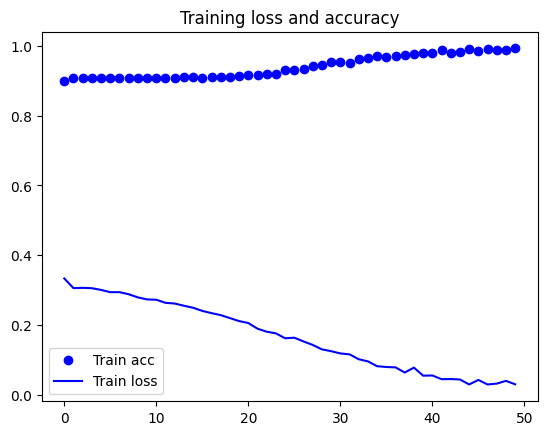

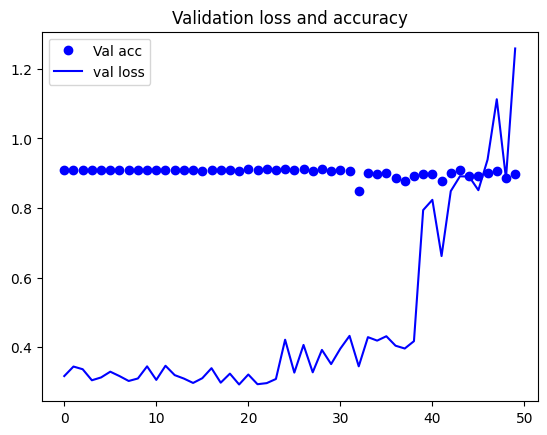

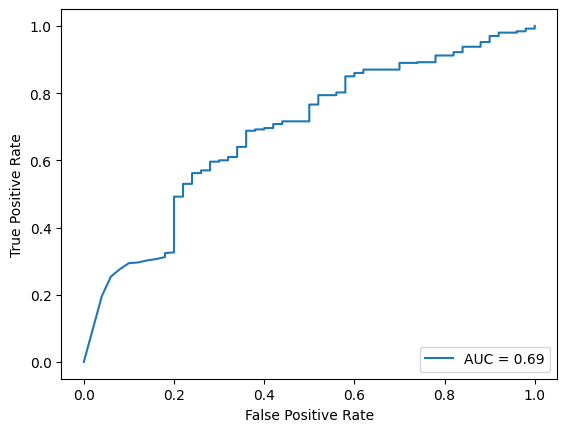

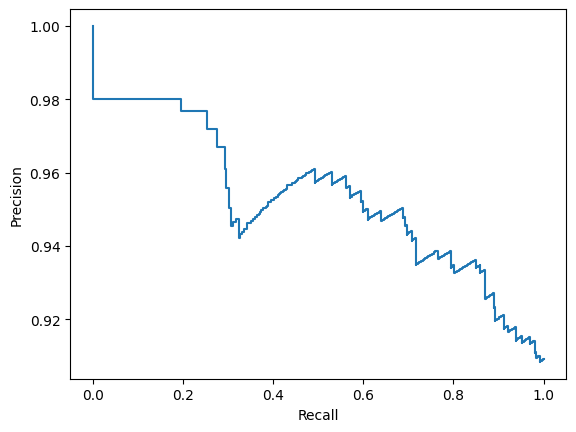

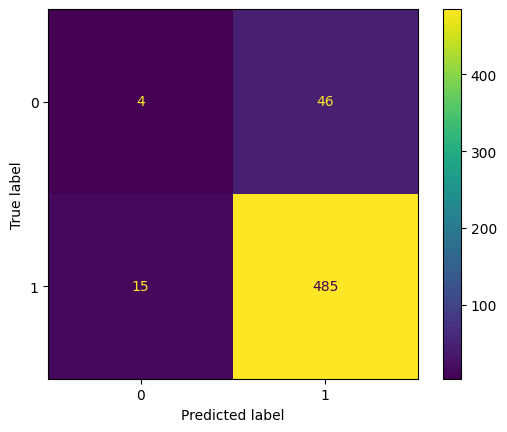

In [13]:
# Load rare dataset
dataset_train_rare = DogCatDataset(root_dir=RARESET_TRAIN_PATH, transform=transform)
dataset_val_rare = DogCatDataset(root_dir=RARESET_VAL_PATH, transform=transform)
dataset_test_rare = DogCatDataset(root_dir=RARESET_TEST_PATH, transform=transform)

dataloader_train_rare = DataLoader(dataset_train_rare, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val_rare = DataLoader(dataset_val_rare, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test_rare = DataLoader(dataset_test_rare, batch_size=BATCH_SIZE, shuffle=False)

# Train and eval
model_rare = ConvNetWithDropout()
criterion_rare = nn.BCELoss()
optimizer_rare = torch.optim.RMSprop(model_rare.parameters(), lr=LR)

epoch_hist_rare, train_loss_hist_rare, train_acc_hist_rare, val_loss_hist_rare, val_acc_hist_rare = train(model_rare, criterion_rare, optimizer_rare, NUM_EPOCH, DEVICE, dataloader_train_rare, dataloader_val_rare)
y_true_rare, y_pred_rare = predict(model_rare, dataloader_test_rare, DEVICE)

plot_loss_acc(epoch_hist_rare, train_acc_hist_rare, train_loss_hist_rare, val_acc_hist_rare, val_loss_hist_rare)
plot_roc_auc(y_true_rare, y_pred_rare)
plot_recall_precision(y_true_rare, y_pred_rare)
plot_confusion_matrix(y_true_rare, y_pred_rare)

**Baseline Case:**
- **Train epoch 0:** The average loss is relatively high (0.693) and the average accuracy is around 0.523, which indicates that the model's performance is poor at the start of training.
- **Train epoch 49:** By epoch 49, the average loss has reduced to around 0.027, and the average accuracy has improved to around 0.733.

**Rare Case:**
- **Train epoch 0:** In the rare dataset, the rare class performs significantly better compared to the baseline. The average loss is lower (0.333), and the average accuracy is higher (0.900).
- **Train epoch 49:** The performance of the rare class remains consistently high, with very little variation in both loss and accuracy. By epoch 49, the average loss is still low (0.0295), and the average accuracy is still high (0.898).

**Observations:**
1. The rare class performs notably better in the rare dataset, maintaining a consistently high accuracy of around 0.909.
2. In the baseline dataset, the rare class starts with lower performance but shows improvement over time.
3. It's important to consider that while the rare class performs better in the rare dataset, the overall model performance might vary between the two datasets. The baseline dataset's accuracy and loss values are lower, suggesting potential struggles in classifying the rare class, but it may perform better on the common class.

In summary, the rare class exhibits superior performance in the rare dataset.


Train epoch: 0, avg loss: 0.1972936987876892, avg acc: 0.9054545164108276
Val epoch: 0, avg loss: 0.856587827205658, avg acc: 0.9090908765792847
Train epoch: 1, avg loss: 0.23640713095664978, avg acc: 0.9090908765792847
Val epoch: 1, avg loss: 0.9220061302185059, avg acc: 0.9090908765792847
Train epoch: 2, avg loss: 0.2723725140094757, avg acc: 0.9090908765792847
Val epoch: 2, avg loss: 0.998192310333252, avg acc: 0.9090908765792847
Train epoch: 3, avg loss: 0.2525878846645355, avg acc: 0.9090908765792847
Val epoch: 3, avg loss: 0.8309139609336853, avg acc: 0.9090908765792847
Train epoch: 4, avg loss: 0.24206694960594177, avg acc: 0.9090908169746399
Val epoch: 4, avg loss: 0.8616946339607239, avg acc: 0.9090908765792847
Train epoch: 5, avg loss: 0.2466767430305481, avg acc: 0.9090908765792847
Val epoch: 5, avg loss: 0.9377396702766418, avg acc: 0.9090908765792847
Train epoch: 6, avg loss: 0.2625681459903717, avg acc: 0.9054545164108276
Val epoch: 6, avg loss: 0.7591791152954102, avg ac

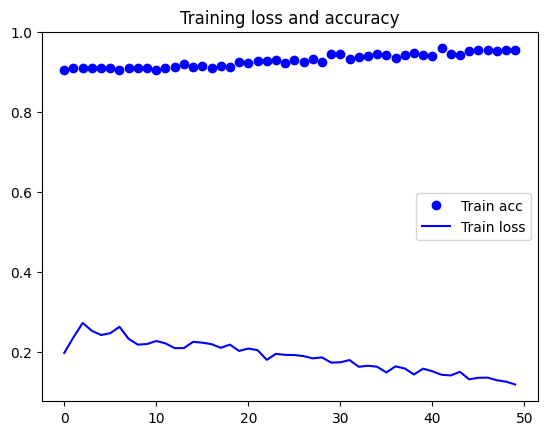

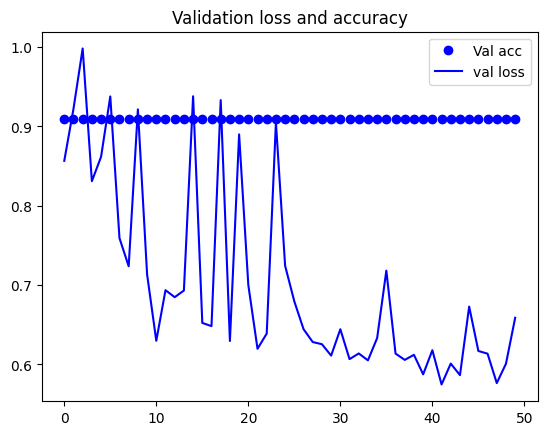

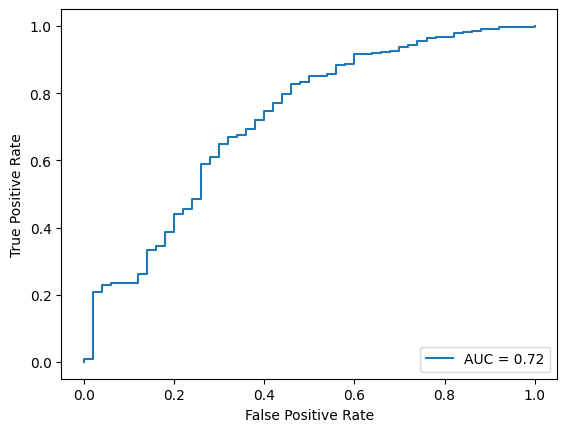

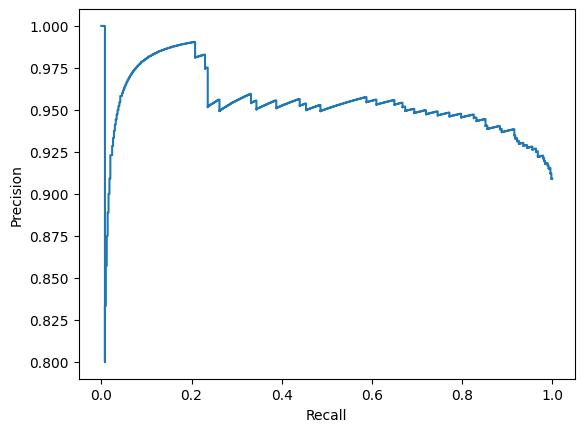

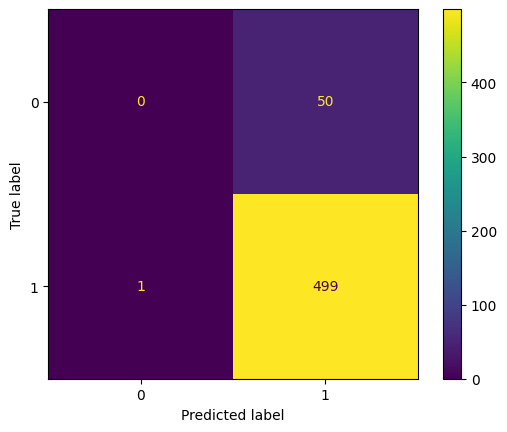

In [14]:
# Method 1: Random Over Sampling
train_class = [100, 1000]
train_weight = [1 / train_class[label.int()] for _, label in dataset_train_rare]
train_sampler = WeightedRandomSampler(weights=torch.tensor(train_weight, dtype=torch.float32), num_samples=len(dataset_train_rare), replacement=False)

val_class = [50, 500]
val_weight = [1 / val_class[label.int()] for _, label in dataset_val_rare]
val_sampler = WeightedRandomSampler(weights=torch.tensor(val_weight, dtype=torch.float32), num_samples=len(dataset_val_rare), replacement=False)

test_class = [50, 500]
test_weight = [1 / test_class[label.int()] for _, label in dataset_test_rare]
test_sampler = WeightedRandomSampler(weights=torch.tensor(val_weight, dtype=torch.float32), num_samples=len(dataset_test_rare), replacement=False)

dataloader_train_rare_balance = DataLoader(dataset_train_rare, BATCH_SIZE, sampler=train_sampler)
dataloader_val_rare_balance = DataLoader(dataset_val_rare, BATCH_SIZE, sampler=val_sampler)
dataloader_test_rare_balance = DataLoader(dataset_test_rare, BATCH_SIZE, sampler=test_sampler)

# Train and eval
model_rare_balance = ConvNetWithDropout()
criterion_rare_balance = nn.BCELoss()
optimizer_rare_balance = torch.optim.RMSprop(model_rare_balance.parameters(), lr=LR)

epoch_hist_rare_balance, train_loss_hist_rare_balance, train_acc_hist_rare_balance, val_loss_hist_rare_balance, val_acc_hist_rare_balance = train(model_rare_balance, criterion_rare_balance, optimizer_rare_balance, NUM_EPOCH, DEVICE, dataloader_train_rare_balance, dataloader_val_rare_balance)
y_true_rare_balance, y_pred_rare_balance = predict(model_rare_balance, dataloader_test_rare_balance, DEVICE)

plot_loss_acc(epoch_hist_rare_balance, train_acc_hist_rare_balance, train_loss_hist_rare_balance, val_acc_hist_rare_balance, val_loss_hist_rare_balance)
plot_roc_auc(y_true_rare_balance, y_pred_rare_balance)
plot_recall_precision(y_true_rare_balance, y_pred_rare_balance)
plot_confusion_matrix(y_true_rare_balance, y_pred_rare_balance)


Train epoch: 0, avg loss: 0.3326606750488281, avg acc: 0.9000003337860107
Val epoch: 0, avg loss: 0.30319249629974365, avg acc: 0.9090909361839294
Train epoch: 1, avg loss: 0.3073241114616394, avg acc: 0.9090912938117981
Val epoch: 1, avg loss: 0.301944375038147, avg acc: 0.9090909361839294
Train epoch: 2, avg loss: 0.30074650049209595, avg acc: 0.9090915322303772
Val epoch: 2, avg loss: 0.3044949471950531, avg acc: 0.9090909361839294
Train epoch: 3, avg loss: 0.29772233963012695, avg acc: 0.9090912938117981
Val epoch: 3, avg loss: 0.308740496635437, avg acc: 0.9090909361839294
Train epoch: 4, avg loss: 0.30298686027526855, avg acc: 0.9090914130210876
Val epoch: 4, avg loss: 0.30325767397880554, avg acc: 0.9090909361839294
Train epoch: 5, avg loss: 0.2954408526420593, avg acc: 0.9090914130210876
Val epoch: 5, avg loss: 0.3017362952232361, avg acc: 0.9090909361839294
Train epoch: 6, avg loss: 0.30261102318763733, avg acc: 0.9090911746025085
Val epoch: 6, avg loss: 0.31281670928001404, a

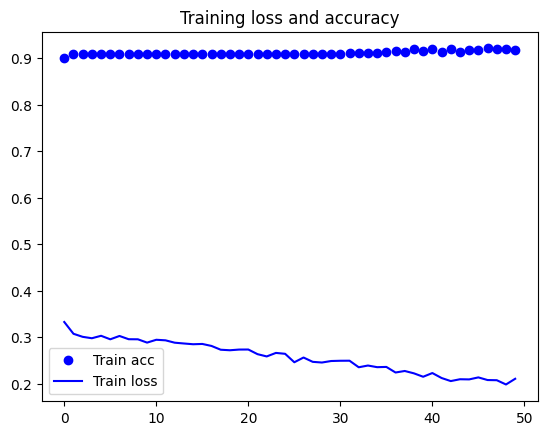

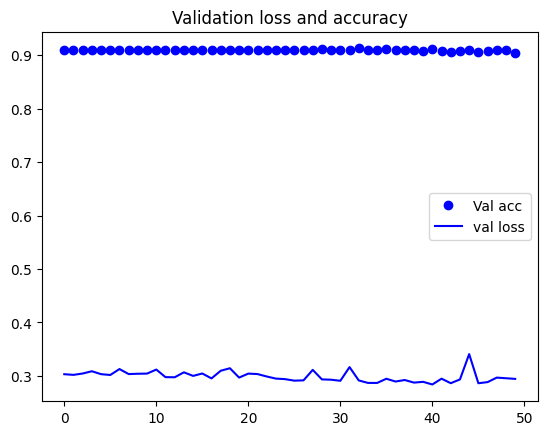

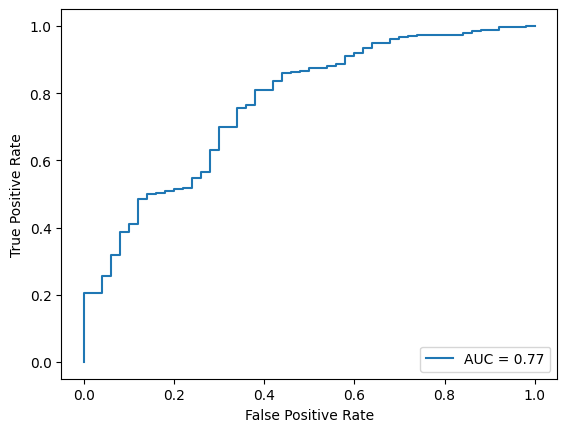

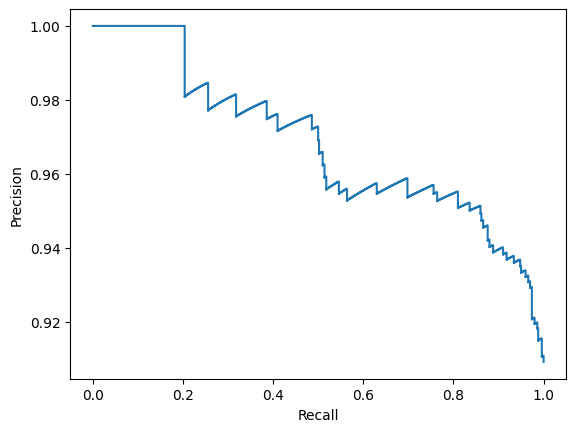

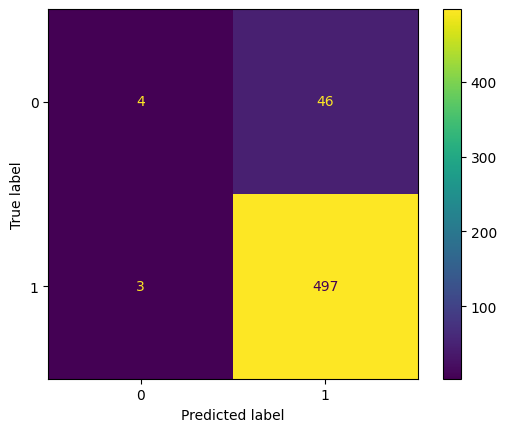

In [15]:
# Method 2: Data augmentation
dataset_train_rare_aug = DogCatDataset(root_dir=RARESET_TRAIN_PATH, transform=transform_with_aug)
dataloader_train_rare_aug = DataLoader(dataset_train_rare_aug, batch_size=BATCH_SIZE, shuffle=True)

# Train and eval
model_rare_aug = ConvNetWithDropout()
criterion_rare_aug = nn.BCELoss()
optimizer_rare_aug = torch.optim.RMSprop(model_rare_aug.parameters(), lr=LR)

epoch_hist_rare_aug, train_loss_hist_rare_aug, train_acc_hist_rare_aug, val_loss_hist_rare_aug, val_acc_hist_rare_aug = train(model_rare_aug, criterion_rare_aug, optimizer_rare_aug, NUM_EPOCH, DEVICE, dataloader_train_rare_aug, dataloader_val_rare)
y_true_rare_aug, y_pred_rare_aug = predict(model_rare_aug, dataloader_test_rare, DEVICE)

plot_loss_acc(epoch_hist_rare_aug, train_acc_hist_rare_aug, train_loss_hist_rare_aug, val_acc_hist_rare_aug, val_loss_hist_rare_aug)
plot_roc_auc(y_true_rare_aug, y_pred_rare_aug)
plot_recall_precision(y_true_rare_aug, y_pred_rare_aug)
plot_confusion_matrix(y_true_rare_aug, y_pred_rare_aug)